In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 104728142.85it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79485363.40it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27010980.30it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13359417.09it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
count = 1200
count_test = 200

train_X = MNIST_train.data.numpy()[:count]
train_Y = MNIST_train.targets.numpy()[:count]
test_X = MNIST_test.data.numpy()[:count_test]
test_Y = MNIST_test.targets.numpy()[:count_test]

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_Y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_Y.shape))

X_train: (1200, 28, 28)
Y_train: (1200,)
X_test:  (200, 28, 28)
Y_test:  (200,)


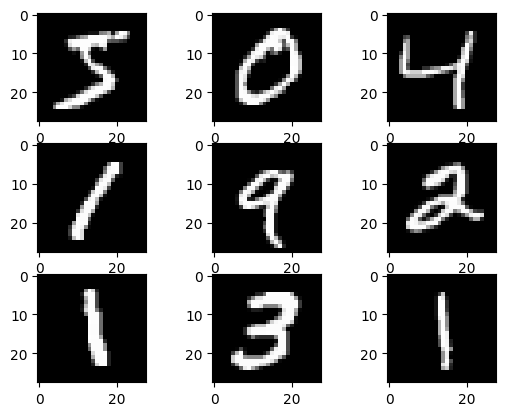

In [4]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

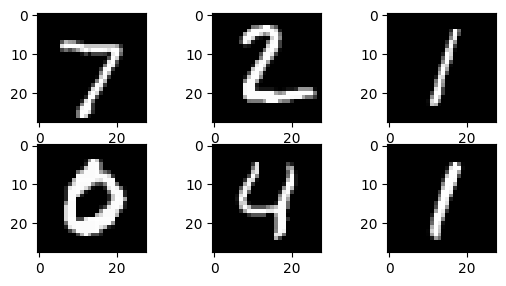

In [5]:
for i in range(6):
    plt.subplot(331 + i)
    plt.imshow(test_X[i], cmap=plt.get_cmap('gray'))

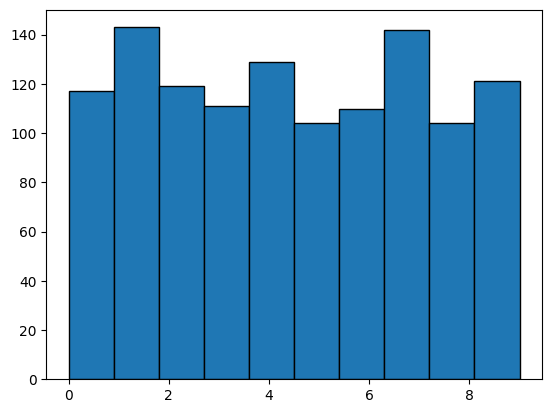

In [6]:
plt.hist(train_Y, bins=10, edgecolor='black')
plt.show()

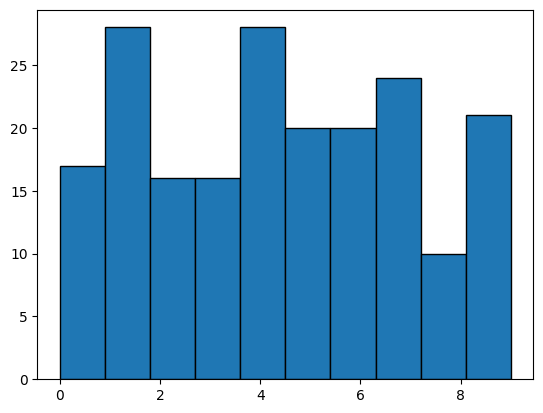

In [7]:
plt.hist(test_Y, bins=10, edgecolor='black')
plt.show()

In [8]:
train_X = np.array(list(map(lambda x: x.flatten() / 256, train_X)))

train_Y = np.array([np.array([int(i == x) for i in range(10)]) for x in train_Y])
test_X = np.array(list(map(lambda x: x.flatten() / 256, test_X)))
test_Y = np.array([np.array([int(i == x) for i in range(10)]) for x in test_Y])

In [9]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_Y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_Y.shape))

X_train: (1200, 784)
Y_train: (1200, 10)
X_test:  (200, 784)
Y_test:  (200, 10)


In [10]:
def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x) / (np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x): return 1/(1+np.exp(-x))

def sigmoid_derivative(x): return sigmoid(x)*(1-sigmoid(x))

def cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    return -np.mean(y_true * np.log(y_pred))

def cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    res = y_pred - y_true
    return res / np.linalg.norm(res)


In [11]:
class LinearLayer:
    def __init__(self, input_size, output_size, optimizer, model):
        self.nag_v = None
        self.adam_m = None
        self.adam_v = None
        self.adam_t = None
        self.adagrad_G = None
        self.inputs = None
        self.weights = np.random.rand(input_size + 1, output_size) - 0.5
        self.optimizer = optimizer
        self.model = model

    def forward(self, inputs, train=True):
        inputs = np.append([1], inputs)

        if train:
            self.inputs = inputs
        return inputs @ self.weights

    def calculate(self):
        return self.model.calculate(self, self.inputs[:-1])

    def backward(self, grad, train=True):
        if not train:
            return (grad @ self.weights.T)[1:]
        accum_grad = (grad @ self.weights.T)[1:]
        step_grad = np.outer(self.inputs, grad)
        if np.linalg.norm(step_grad) != 0:
            step_grad /= np.linalg.norm(step_grad)
        step = None
        match self.optimizer:
            case 0:
                # SGD
                step = step_grad
            case 1:
                # NAG
                if self.nag_v is None:
                    self.nag_v = np.zeros(step_grad.shape)
                self.weights -= self.model.gamma * self.nag_v

                j = self.model.nag_helper(self, self.inputs[1:])
                J = np.outer(self.inputs, j)
                self.weights += self.model.gamma * self.nag_v
                self.nag_v = self.model.gamma * self.nag_v + self.model.lr * J
                step = self.nag_v
            case 2:
                # Adagrad
                if self.adagrad_G is None:
                    self.adagrad_G = np.zeros(self.weights.shape)
                self.adagrad_G += step_grad**2
                step = self.model.lr / np.sqrt(self.adagrad_G+10e-6) * step_grad
            case 3:
                # Adam
                if self.adam_t is None:
                    self.adam_t = 0
                    self.adam_m = np.zeros(self.weights.shape)
                    self.adam_v = np.zeros(self.weights.shape)
                self.adam_t += 1
                self.adam_m = self.model.beta1 * self.adam_m + (1 - self.model.beta1) * step_grad
                self.adam_v = self.model.beta2 * self.adam_v + (1 - self.model.beta2) * step_grad**2
                m = self.adam_m / (1 - self.model.beta1**self.adam_t)
                v = self.adam_v / (1 - self.model.beta2**self.adam_t)
                step = self.model.lr * m / np.sqrt(v + 10e-8)


        self.weights -= step

        return accum_grad


In [12]:
class ActivationLayer:
    def __init__(self, activation, activation_derivative):
        self.inputs = None
        self.activation = activation
        self.activation_derivative = activation_derivative
    def forward(self, inputs, train=True):
        self.inputs = inputs
        return self.activation(inputs)
    def backward(self, grad, train=True):
        return grad * self.activation_derivative(self.inputs)


In [13]:
class Perceptron:
    def __init__(self, input_size, sizes, loss, loss_derivative, optimizer, lr, gamma, beta1, beta2):
        self.last_true = None
        self.layers = []
        self.beta1 = beta1
        self.beta2 = beta2
        self.gamma = gamma
        prev_size = input_size
        for size in sizes:
            self.layers.append(LinearLayer(prev_size, size, optimizer, self))
            self.layers.append(ActivationLayer(sigmoid, sigmoid_derivative))
            prev_size = size
        self.layers.append(LinearLayer(prev_size, 10, optimizer, self))
        self.layers.append(ActivationLayer(softmax, lambda x: softmax(x) * (1 - softmax(x))))
        self.loss = loss
        self.loss_derivative = loss_derivative
        self.lr = lr

    def forward(self, inputs, train=True):
        result = inputs
        for layer in self.layers:
            result = layer.forward(result, train)
        return result

    def backward(self, y_true, y_pred):
        grad = self.loss_derivative(y_true, y_pred)
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, inputs, y_true):
        self.last_true = y_true
        y_pred = self.forward(inputs, True)
        loss = self.loss(y_true, y_pred)
        self.backward(y_true, y_pred)
        return y_pred, loss

    def calculate(self, layer, inputs):
        place = self.layers.index(layer)
        result = inputs
        for layer in self.layers[place:]:
            result = layer.forward(result, False)
        return self.loss(self.last_true, result)

    def nag_helper(self, layer, inputs):
        place = self.layers.index(layer)
        result = inputs
        for layer in self.layers[place:]:
            result = layer.forward(result, False)
        grad = self.loss_derivative(self.last_true, result)
        for layer in self.layers[place + 1:][::-1]:
            grad = layer.backward(grad, False)
        return grad

    def train(self, epochs):
        accuracy = []
        loss_arr = []
        for _ in range(epochs):
            running_accuracy = 0
            running_loss = 0
            for inputs, y_true in zip(train_X, train_Y):
                y_pred, loss = self.fit(inputs, y_true)
                pred = np.argmax(y_pred)
                running_loss += loss
                running_accuracy += (np.argmax(y_true) == pred)
            accuracy.append(running_accuracy / len(train_X))
            loss_arr.append(running_loss / len(train_X))
        return accuracy, loss_arr

    def validate(self):
        running_accuracy = 0
        running_loss = 0
        for inputs, y_true in zip(test_X, test_Y):
            y_pred = self.forward(inputs, False)
            loss = self.loss(y_true, y_pred)
            pred = np.argmax(y_pred)
            running_loss += loss
            running_accuracy += (np.argmax(y_true) == pred)
        return running_loss / len(test_X), running_accuracy / len(test_X)

In [29]:
class Individual:
    def __init__(self, num_hidden_layers, num_neurons):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

def evaluate_individual(individual, loss, loss_der, optimizer, learning_rate, gamma, beta1, beta2):
    perceptron = Perceptron(28 * 28, [individual.num_neurons for _ in range(individual.num_hidden_layers)], loss, loss_der, optimizer, learning_rate, gamma, beta1, beta2)

    accuracy, loss = perceptron.train(5)

    return accuracy[-1], loss[-1]


def genetic_algorithm(population_size, generations, loss, loss_der, optimizer, learning_rate, gamma, beta1, beta2):
    best_individual = None
    population = [Individual(num_hidden_layers=np.random.randint(1, 4), num_neurons=np.random.randint(16, 256)) for _ in range(population_size)]
    for generation in tqdm(range(generations)):
        fitness = np.array([evaluate_individual(individual, loss, loss_der, optimizer, learning_rate, gamma, beta1, beta2) for individual in population], dtype=[("first", float), ("second", float)])

        # отбор лучших (по лоссу)
        sorted_indices = np.argsort(fitness, order='second')
        population = [population[i] for i in sorted_indices]
        elite = population[:int(0.2 * population_size)]

        # кроссовер
        offspring = []
        for _ in range(int(0.8*population_size)):
            parent1 = np.random.choice(elite)
            parent2 = np.random.choice(elite)
            child = Individual(
                num_hidden_layers=np.random.choice([parent1.num_hidden_layers, parent2.num_hidden_layers]),
                num_neurons=np.random.choice([parent1.num_neurons, parent2.num_neurons])
            )
            offspring.append(child)

        # мутации
        for child in offspring:
            if np.random.rand() < 0.15:
                child.num_hidden_layers = np.random.randint(1, 4)
            if np.random.rand() < 0.15:
                child.num_neurons = np.random.randint(16, 256)

        population = elite + offspring

        best_individual = population[0]
        print(f"Generation {generation + 1}, Best accuracy: {fitness[0][0]}, Best_loss: {fitness[0][1]}")

    return best_individual


In [31]:
best = genetic_algorithm(25, 5, cross_entropy, cross_entropy_derivative, 3, 0.0065, None, 0.9, 0.999)

print(best.num_neurons)
print(best.num_hidden_layers)

 20%|██        | 1/5 [09:46<39:06, 586.61s/it]

Generation 1, Best accuracy: 0.8566666666666667, Best_loss: 0.17229217007572528


 40%|████      | 2/5 [28:22<44:53, 897.96s/it]

Generation 2, Best accuracy: 0.9058333333333334, Best_loss: 0.1680141664655133


 60%|██████    | 3/5 [46:52<33:09, 994.83s/it]

Generation 3, Best accuracy: 0.905, Best_loss: 0.16676037878158181


 80%|████████  | 4/5 [1:07:22<18:07, 1087.74s/it]

Generation 4, Best accuracy: 0.8941666666666667, Best_loss: 0.1650570496055571


100%|██████████| 5/5 [1:27:04<00:00, 1044.90s/it]

Generation 5, Best accuracy: 0.905, Best_loss: 0.16816305009968982
248
2
